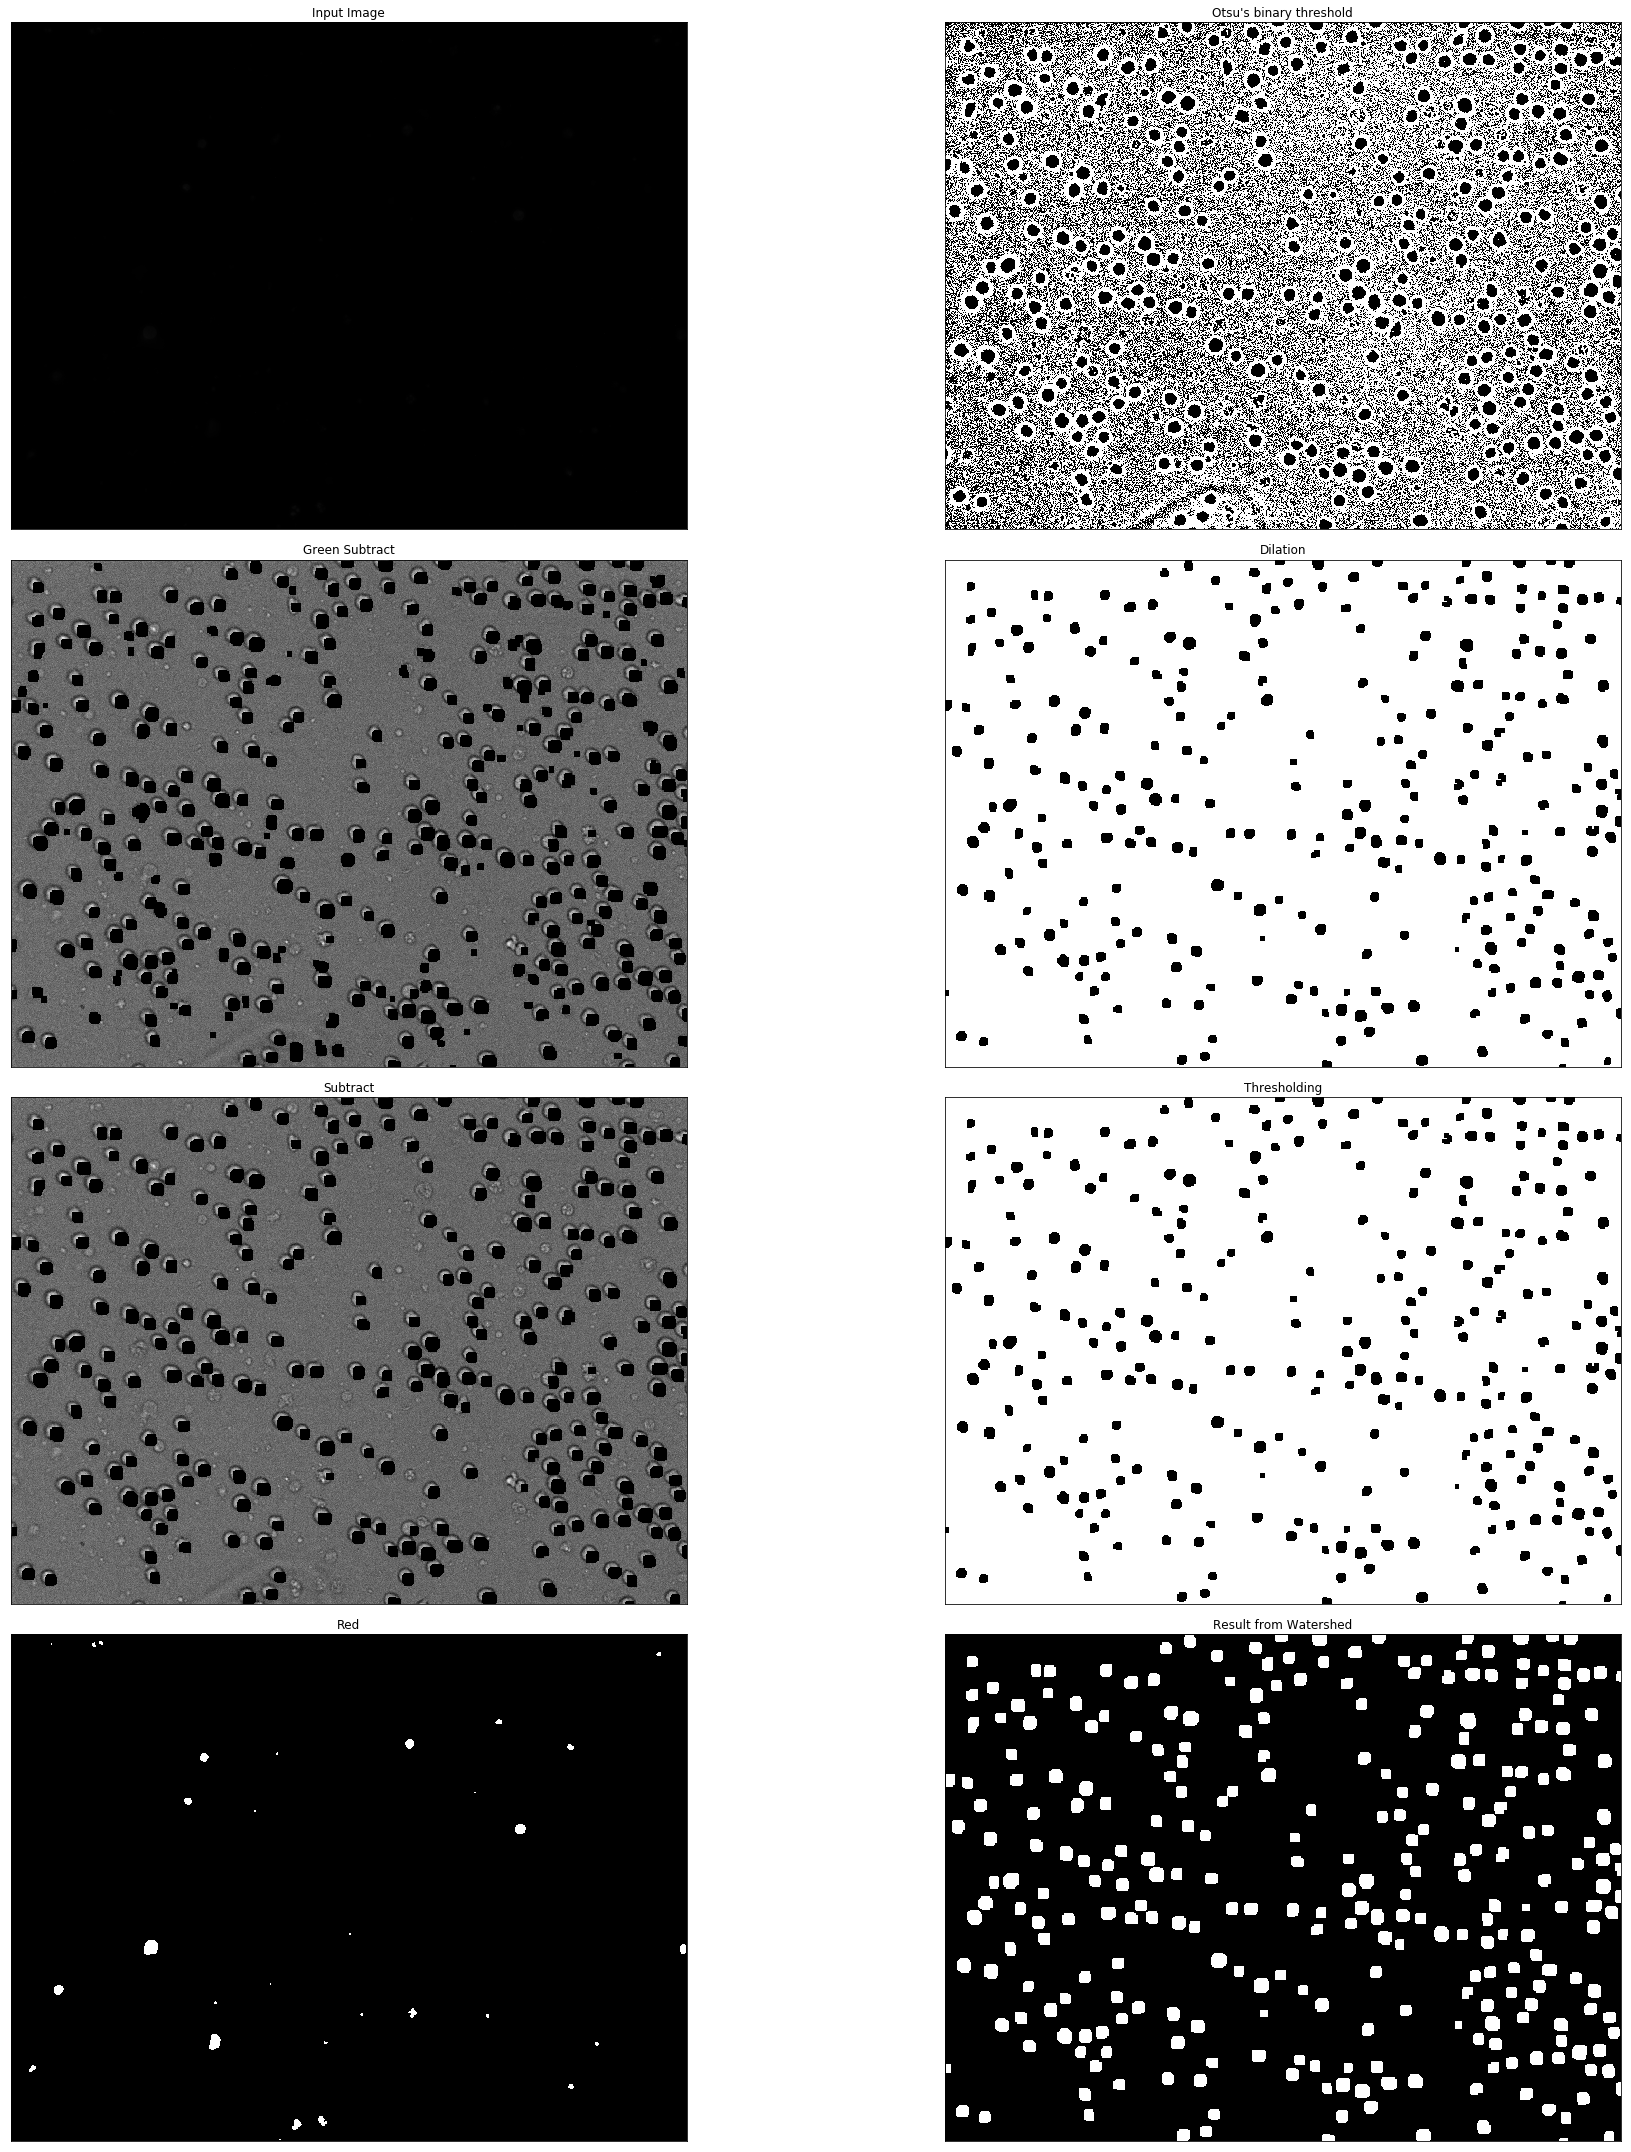

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# img = cv2.imread("images\\Scene1Interval072_TxRed.png")
# img2 = cv2.imread("images\\Scene1Interval072_TxRed.png")

img = cv2.imread("images\\Scene1Interval017_TRANS_small.png")
img2 = cv2.imread("images\\Scene1Interval017_TRANS_small.png")
img_red = cv2.imread("images\\Scene1Interval017_TxRed.tif")
img_red2 = cv2.imread("images\\Scene1Interval017_TxRed.tif")
img_green = cv2.imread("images\\Scene1Interval017_GFP.png")
img_green2 = cv2.imread("images\\Scene1Interval017_GFP.png")


#img = cv2.imread("images\\Scene1Interval036_TRANS.png")
#img2 = cv2.imread("images\\Scene1Interval036_TRANS.png")

#img = cv2.imread("images\\Scene1Interval067_PHASE.png")
#img2 = cv2.imread("images\\Scene1Interval067_PHASE.png")


# img = cv2.imread("images\\Scene1Interval031_GFP.png")
# img2 = cv2.imread("images\\Scene1Interval031_GFP.png")

#img = np.array(i, dtype=np.uint16) # This line only change the type, not values

#img = np.float32(img)
#img = img * 1.0

#img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
#img.convertTo(img, cv2.32F, 1.0)

b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#gray = cv2.GaussianBlur(gray,(1,1),1)

clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3,3))
gray = clahe.apply(gray)

ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)



#green test

b,g,r = cv2.split(img_green)

gray_green = cv2.cvtColor(img_green,cv2.COLOR_BGR2GRAY)

#ret, thresh3 = cv2.threshold(gray_green,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
thresh3 = cv2.adaptiveThreshold(gray_green, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 101, 2)



# red test
b,g,r = cv2.split(img_red)
rgb_img = cv2.merge([r,g,b])

gray_red = cv2.cvtColor(img_red,cv2.COLOR_BGR2GRAY)

#gray = cv2.GaussianBlur(gray,(1,1),1)

clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3,3))
gray_red = clahe.apply(gray_red)

ret, thresh4 = cv2.threshold(gray_red,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
#thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 63, 2)

#thresh = cv2.fastNlMeansDenoising(thresh,thresh,7,21,7)	

#thresh = cv2.medianBlur(thresh,3)

#img *= 256 # Now we get the good values in 16 bit format

# noise removal
kernel = np.ones((2,2),np.uint8)
kernelClosing = np.ones((4,4),np.uint8)
kernelClosing_green = np.ones((3,3),np.uint8)

opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernelClosing, iterations = 3)

opening_green = cv2.morphologyEx(thresh3,cv2.MORPH_OPEN,kernel, iterations = 3)
closing_green = cv2.morphologyEx(thresh3,cv2.MORPH_CLOSE,kernelClosing_green, iterations = 3)

opening_red = cv2.morphologyEx(thresh4,cv2.MORPH_OPEN,kernel, iterations = 3)
closing_red = cv2.morphologyEx(thresh4,cv2.MORPH_CLOSE,kernel, iterations = 3)

# sure background area red
#sure_bg = cv2.dilate(closing,kernel,iterations=2)

# sure background area PHASE
sure_bg = cv2.dilate(closing,kernel,iterations=1)

sure_bg_green = cv2.dilate(closing_green,kernel,iterations=1)

sure_bg_red = cv2.dilate(closing_red,kernel,iterations=1)


# sure background area
#sure_bg = cv2.erode(closing,kernel,iterations=1)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)

dist_transform_green = cv2.distanceTransform(sure_bg_green,cv2.DIST_L2,3)

dist_transform_red = cv2.distanceTransform(sure_bg_red,cv2.DIST_L2,3)


# Threshold RED
# ret, sure_fg = cv2.threshold(dist_transform,0.02*dist_transform.max(),255,0)

# Threshold GREEN
#ret, sure_fg = cv2.threshold(dist_transform,0.02*dist_transform.max(),255,0)




#dist_transform = cv2.GaussianBlur(dist_transform,(1,1),5)


# Threshold PHASE
ret, sure_fg = cv2.threshold(dist_transform,0.005*dist_transform.max(),255,0)


ret, sure_fg_green = cv2.threshold(dist_transform_green,0.005*dist_transform.max(),255,0)

ret, sure_fg_red = cv2.threshold(dist_transform_red,0.005*dist_transform.max(),255,0)


#sure_fg = cv2.medianBlur(sure_fg,5)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img,markers)

img[markers == 1] = [255,255,255]
img[markers != 1] = [0,0,0]

img[markers == -1] = [0,0,0]


# Finding unknown region green
sure_fg_green = np.uint8(sure_fg_green)
unknown_green = cv2.subtract(sure_bg_green,sure_fg_green)

# Marker labelling
ret, markers_green = cv2.connectedComponents(sure_fg_green)

# Add one to all labels so that sure background is not 0, but 1
markers_green = markers_green+1

# Now, mark the region of unknown with zero
markers_green[unknown_green==255] = 0

markers_green = cv2.watershed(img_green,markers_green)

img_green[markers_green == 1] = [255,255,255]
img_green[markers_green != 1] = [0,0,0]

img_green[markers_green == -1] = [0,0,0]


# Finding unknown region red
sure_fg_red = np.uint8(sure_fg_red)
unknown_red = cv2.subtract(sure_bg_red,sure_fg_red)

# Marker labelling
ret, markers_red = cv2.connectedComponents(sure_fg_red)

# Add one to all labels so that sure background is not 0, but 1
markers_red = markers_red+1

# Now, mark the region of unknown with zero
markers_red[unknown_green==255] = 0

markers_red = cv2.watershed(img_red,markers_red)

img_red[markers_red == 1] = [255,255,255]
img_red[markers_red != 1] = [0,0,0]

img_red[markers_red == -1] = [0,0,0]



#img = cv2.morphologyEx(img,cv2.MORPH_OPEN,kernel, iterations = 2)
#img = cv2.morphologyEx(img,cv2.MORPH_CLOSE,kernelClosing, iterations = 2)

img = cv2.dilate(img, kernel, iterations = 5)

img3 = cv2.subtract(img2,img)

# green
img_green = cv2.dilate(img_green, kernel, iterations = 5)

img4 = cv2.subtract(img_green,img_green2)

#red test


ret, thresh2 = cv2.threshold(gray_red,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#img4= cv2.subtract(img2,cv2.bitwise_or(cv2.bitwise_or(img,img_green), img_red));

img4= cv2.subtract(img2,cv2.bitwise_or(img,img_green));


# sure_fg = cv2.erode(sure_fg, markers)

fig = plt.figure(figsize=(30,30))

#plt.imshow(img)

plt.subplot(421),plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(422),plt.imshow(thresh, 'gray')
plt.title("Otsu's binary threshold"), plt.xticks([]), plt.yticks([])

plt.subplot(423),plt.imshow(img4, 'gray')
plt.title("Green Subtract"), plt.xticks([]), plt.yticks([])
plt.subplot(424),plt.imshow(sure_bg, 'gray')
plt.title("Dilation"), plt.xticks([]), plt.yticks([])

plt.subplot(425),plt.imshow(img3, 'gray')
plt.title("Subtract"), plt.xticks([]), plt.yticks([])
plt.subplot(426),plt.imshow(sure_fg, 'gray')
plt.title("Thresholding"), plt.xticks([]), plt.yticks([])

plt.subplot(427),plt.imshow(img_red, 'gray')
plt.title("Red"), plt.xticks([]), plt.yticks([])

plt.subplot(428),plt.imshow(img, 'gray')
plt.title("Result from Watershed"), plt.xticks([]), plt.yticks([])


# plt.imsave(img, "D:\\University\\FinalProj\\detectionTest\\Scene1Interval072_TxRed_water.png")

plt.tight_layout()
plt.show()


fig.savefig("D:\\University\\FinalProj\\detectionTest\\Scene1Interval072_TxRed - THRESH.png")
